## setup and dataloading

In [ ]:
import sys
sys.path.insert(0, "..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

from mergedna.dataloader import dataloader, merge_sequences
from mergedna.backbone import MergeDNAModel
from mergedna.merging import bipartite_soft_matching

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


/Users/sanjukta/probable-adventure/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths
DATA_DIR = "../data/human_nontata_promoters/"
CHECKPOINT_PATH = "../checkpoints/mergedna_pretrain.pt"

# Create checkpoint directory
import os
os.makedirs("../checkpoints", exist_ok=True)

In [3]:
#variables
batch = 4

In [4]:
pretrain_sequences = dataloader(DATA_DIR)
sequences = merge_sequences(pretrain_sequences)

test
positive
negative
train
positive
negative


## train

In [5]:
test_seq = sequences[0]
print(test_seq)
print(len(test_seq))

CAGGAATCGAACACTAGGAATCCTACTCGATAGGTGGCACGGATTGCGGAGAGAAACTTCGCGTGGGGGGGAACCCTAGGGTGTACCCTTCGGGGACTGCACGCGCTCTTCATCTTTCCTGGCTGCCGTCCTCCTCCCGGCCGCAGGGGGCGCTGGGGAGCCGGCCTCGGGGCCGCGTGCTGATTGGCTCCTCGGGAAACAGACGAGACTGGACGTTGGGCCGGGCGGGCGTCGCCTCTGCGGCGTGTGTC
251


In [6]:
DNA_VOCAB = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 0}

class DNADataset(Dataset):
    """Dataset for DNA sequences with variable lengths."""
    def __init__(self, sequences):
        self.sequences = sequences
        # No max_len needed here anymore
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].strip().upper()
        # Convert full sequence to indices without truncation
        indices = [DNA_VOCAB.get(base, 0) for base in seq]
        
        # Return as tensor immediately (no internal padding)
        return torch.tensor(indices, dtype=torch.long)

# Test the dataset
dataset = DNADataset(test_seq)
print(f"Dataset size: {len(dataset)}")
print(dataset.__getitem__(1))

Dataset size: 251
tensor([0])


In [7]:
DIM = 4
LATENT_ENC_DEPTH = 2
LATENT_DEC_DEPTH = 2

BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCHS = 10
LAMBDA_LATENT = 0.25



In [8]:
class LocalEncoder(nn.Module):
    """
    Local Encoder: Embeds DNA bases and performs token merging via pooling.
    Maps N bases -> L tokens (L < N) with source matrix tracking.
    Uses simple average pooling for robust merging.
    """
    def __init__(self, dim, vocab_size=4, merge_ratio=0.5):
        super().__init__()
        self.dim = dim
        self.merge_ratio = merge_ratio
        self.embed = nn.Embedding(vocab_size, dim)
        self.pos_embed = nn.Parameter(torch.randn(1, 512, dim) * 0.02)
        
        # Local attention for context before merging
        self.local_attn = nn.TransformerEncoderLayer(
            d_model=dim, nhead=4, dim_feedforward=dim*4, 
            dropout=0.1, batch_first=True
        )
        
        # Learnable merge weights
        self.merge_proj = nn.Linear(dim, 1)
    
    def forward(self, x):
        """
        x: [B, N] indices or [B, N, 4] one-hot
        Returns: z_l [B, L, D], source_map [B, N]
        """
        if x.dim() == 3:  # one-hot
            x_idx = x.argmax(dim=-1)
        else:
            x_idx = x
        
        B, N = x_idx.shape
        
        # Embed
        z = self.embed(x_idx)  # [B, N, D]
        z = z + self.pos_embed[:, :N, :]
        
        # Local attention
        z = self.local_attn(z)
        
        # Simple pooling-based merging (pairs of adjacent tokens)
        # This is more robust than bipartite matching
        target_len = max(int(N * self.merge_ratio), 1)
        
        # Merge by averaging pairs of tokens
        # Pad to even length if needed
        if N % 2 == 1:
            z = F.pad(z, (0, 0, 0, 1))  # Pad sequence dim
            N_padded = N + 1
        else:
            N_padded = N
        
        # Reshape and average pairs: [B, N, D] -> [B, N/2, 2, D] -> [B, N/2, D]
        z_pairs = z.view(B, N_padded // 2, 2, self.dim)
        z_merged = z_pairs.mean(dim=2)  # [B, N/2, D]
        
        # Build source map: each original token points to its merged token
        # Token 0,1 -> 0, Token 2,3 -> 1, etc.
        source_map = torch.arange(N, device=z.device) // 2
        source_map = source_map.unsqueeze(0).expand(B, -1).clone()  # [B, N]
        
        return z_merged, source_map


class LocalDecoder(nn.Module):
    """
    Local Decoder: Unmerges tokens back to original length and refines.
    Maps L tokens -> N bases using source matrix.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        # Refinement layers after unmerging
        self.refine = nn.TransformerEncoderLayer(
            d_model=dim, nhead=2, dim_feedforward=dim*2,
            dropout=0.1, batch_first=True
        )
        self.proj = nn.Linear(dim, dim)
    
    def forward(self, z_l, source_map):
        """
        z_l: [B, L, D] merged tokens
        source_map: [B, N] ownership map (indices into L)
        Returns: x_hat [B, N, D]
        """
        B, L, D = z_l.shape
        N = source_map.shape[1]
        
        # Unmerge: broadcast L tokens back to N positions using source_map
        indices = source_map.unsqueeze(-1).expand(-1, -1, D)  # [B, N, D]
        x_unmerged = torch.gather(z_l, 1, indices)  # [B, N, D]
        
        # Refine
        x_refined = self.refine(x_unmerged)
        
        return self.proj(x_refined)

# Test the components
test_input = dataset[0].unsqueeze(0).to(device)
local_enc = LocalEncoder(DIM).to(device)
local_dec = LocalDecoder(DIM).to(device)

z_l, s_map = local_enc(test_input)
x_hat = local_dec(z_l, s_map)

print(f"Input shape: {test_input.shape}")
print(f"Latent shape: {z_l.shape}")
print(f"Source map shape: {s_map.shape}")
print(f"Reconstructed shape: {x_hat.shape}")


Input shape: torch.Size([1, 1])
Latent shape: torch.Size([1, 1, 4])
Source map shape: torch.Size([1, 1])
Reconstructed shape: torch.Size([1, 1, 4])


In [ ]:
class LocalEncoder(nn.Module):
    def __init__(self, dim, vocab_size=4, merge_ratio=0.5):
        super().__init__()
        self.dim = dim
        self.merge_ratio = merge_ratio
        
        # Embeddings
        self.embed = nn.Embedding(vocab_size, dim)
        # Position embedding (large buffer)
        self.pos_embed = nn.Parameter(torch.randn(1, 2048, dim) * 0.02)
        
        # Pre-merge Context Processing
        self.local_attn = nn.TransformerEncoderLayer(
            d_model=dim, nhead=4, dim_feedforward=dim*4, 
            dropout=0.1, batch_first=True
        )
        
        # --- The Scorer ---
        # Projects tokens to a metric space for matching
        self.metric_proj = nn.Linear(dim, dim // 4)

    def forward(self, x):
        """
        x: [B, N] indices
        Returns: 
            x_merged: [B, L, D]
            source_map: [B, N] -> Points every original token to its new index in L
        """
        if x.dim() == 3: x_idx = x.argmax(dim=-1)
        else: x_idx = x
            
        B, N = x_idx.shape
        
        # 1. Embed & Context
        x = self.embed(x_idx) 
        x = x + self.pos_embed[:, :N, :]
        x = self.local_attn(x)
        
        # 2. Determine Number of Merges (r)
        # Typically merge_ratio=0.5 means reducing length by half
        r = int(N * self.merge_ratio)
        if r > N // 2: r = N // 2 # Cannot merge more than 50% in one bipartite pass
        
        # 3. Compute Metrics & Find Matches
        metric = self.metric_proj(x)
        node_indices, top_b_indices = bipartite_soft_matching(metric, r)
        
        # If no merges needed (sequence too short)
        if r == 0:
            source_map = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1)
            return x, source_map

        # --- 4. Execute the Merge (The Complex Part) ---
        
        # Helper: Convert local B-indices to Global Indices
        # node_indices values are local A-indices (0..N/2). 
        # top_b_indices are local B-indices (0..N/2).
        
        # Global index of the Source (B) tokens being merged:
        src_idx = top_b_indices * 2 + 1       # Odds
        
        # Global index of the Destination (A) tokens they merge into:
        # We find which A token the selected B tokens wanted:
        dst_local = torch.gather(node_indices, 1, top_b_indices)
        dst_idx = dst_local * 2               # Evens
        
        # 4a. Update Features (Add B to A)
        # We perform a Weighted Sum or Average. For simplicity: Average.
        # x[dst] = (x[dst] + x[src]) / 2
        
        # Gather features of source tokens
        src_features = torch.gather(x, 1, src_idx.unsqueeze(-1).expand(-1, -1, self.dim))
        
        # Add to destination (Scatter Add)
        # Note: We clone x to avoid in-place errors during backprop
        x_out = x.clone()
        x_out.scatter_add_(1, dst_idx.unsqueeze(-1).expand(-1, -1, self.dim), src_features)
        
        # Normalize (Divide by 2 where merge happened)
        # Create a count tensor
        counts = torch.ones(B, N, 1, device=x.device)
        counts.scatter_add_(1, dst_idx.unsqueeze(-1).expand(-1, -1, 1), 
                            torch.ones(B, r, 1, device=x.device))
        x_out = x_out / counts
        
        # 4b. Construct Source Map
        # We need to track: "Original Token i -> Final Token j"
        
        # Step A: Who owns whom?
        # Initially, everyone owns themselves.
        ownership = torch.arange(N, device=x.device).unsqueeze(0).expand(B, -1).clone()
        
        # If src merges into dst, change src's owner to dst
        ownership.scatter_(1, src_idx, dst_idx)
        
        # Step B: Remove the merged tokens
        # Create a mask of "Kept" tokens (All tokens minus the specific src_idx we removed)
        mask = torch.ones(B, N, dtype=torch.bool, device=x.device)
        mask.scatter_(1, src_idx, False)
        
        # Apply mask to features to get final output
        # x_merged needs to be flattened properly per batch
        # Result shape: [B, N-r, D]
        flat_features = x_out[mask].view(B, N - r, self.dim)
        
        # Step C: Renumber the Source Map
        # The ownership map currently points to indices like 0, 2, 4, 10...
        # But the output tensor indices are 0, 1, 2, 3...
        # We need to map [0, 2, 4, 10] -> [0, 1, 2, 3]
        
        # Calculate new indices for every position
        # cumsum of the mask gives the new index (1-based), so subtract 1
        new_indices = torch.cumsum(mask.long(), dim=1) - 1
        
        # Map the ownership values to these new indices
        # We gather the new index for every value in 'ownership'
        # source_map[i] = new_indices[ownership[i]]
        
        # We have to be careful with batching here.
        # ownership contains values 0..N. new_indices is [B, N].
        # We can use gather.
        source_map = torch.gather(new_indices, 1, ownership)
        
        return flat_features, source_map

In [9]:
# Initialize model components
local_encoder = LocalEncoder(DIM, merge_ratio=0.5).to(device)
local_decoder = LocalDecoder(DIM).to(device)

# Create the full MergeDNA model
model = MergeDNAModel(
    local_encoder=local_encoder,
    local_decoder=local_decoder,
    dim=DIM,
    latent_enc_depth=LATENT_ENC_DEPTH,
    latent_dec_depth=LATENT_DEC_DEPTH,
    vocab_size=4
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 3,526
Trainable parameters: 3,526


In [10]:
# Create DataLoader
train_loader = DataLoader(
    dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"Number of batches: {len(train_loader)}")
print(f"Batch size: {BATCH_SIZE}")


Number of batches: 63
Batch size: 4


In [11]:
def train_epoch(model, dataloader, optimizer, device, lambda_latent=0.25):
    """Train for one epoch."""
    model.train()
    
    epoch_losses = {'total': [], 'mtr': [], 'latent': [], 'amtm': []}
    
    pbar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(pbar):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        try:
            loss, logs = model.forward_train(batch, lambda_latent=lambda_latent)
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_losses['total'].append(loss.item())
        epoch_losses['mtr'].append(logs['loss_mtr'])
        epoch_losses['latent'].append(logs['loss_latent'])
        epoch_losses['amtm'].append(logs['loss_amtm'])
        
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'mtr': f"{logs['loss_mtr']:.3f}",
            'amtm': f"{logs['loss_amtm']:.3f}"
        })
    
    return {k: np.mean(v) for k, v in epoch_losses.items()}


In [12]:
# Initialize optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Training history
history = {'total': [], 'mtr': [], 'latent': [], 'amtm': [], 'lr': []}

print("Starting pre-training...")
print("="*60)

best_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    epoch_losses = train_epoch(model, train_loader, optimizer, device, lambda_latent=LAMBDA_LATENT)
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    for key in ['total', 'mtr', 'latent', 'amtm']:
        history[key].append(epoch_losses[key])
    history['lr'].append(current_lr)
    
    print(f"  Total: {epoch_losses['total']:.4f} | MTR: {epoch_losses['mtr']:.4f} | Latent: {epoch_losses['latent']:.4f} | AMTM: {epoch_losses['amtm']:.4f}")
    
    if epoch_losses['total'] < best_loss:
        best_loss = epoch_losses['total']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'history': history
        }, CHECKPOINT_PATH)
        print(f"  ✓ Saved best model (loss: {best_loss:.4f})")

print("\n" + "="*60)
print("Pre-training complete!")


Starting pre-training...

Epoch 1/10


Training: 100%|██████████| 63/63 [00:10<00:00,  5.94it/s, loss=3.0525, mtr=1.130, amtm=1.641]


  Total: 3.2179 | MTR: 1.3073 | Latent: 1.3131 | AMTM: 1.5823
  ✓ Saved best model (loss: 3.2179)

Epoch 2/10


Training: 100%|██████████| 63/63 [00:03<00:00, 17.16it/s, loss=2.7325, mtr=0.992, amtm=1.492]


  Total: 2.6817 | MTR: 0.9549 | Latent: 0.9829 | AMTM: 1.4810
  ✓ Saved best model (loss: 2.6817)

Epoch 3/10


Training: 100%|██████████| 63/63 [00:03<00:00, 17.46it/s, loss=3.1013, mtr=1.357, amtm=1.427]


  Total: 2.5399 | MTR: 0.8912 | Latent: 0.8859 | AMTM: 1.4272
  ✓ Saved best model (loss: 2.5399)

Epoch 4/10


Training: 100%|██████████| 63/63 [00:03<00:00, 17.47it/s, loss=3.2430, mtr=1.292, amtm=1.652]


  Total: 2.4359 | MTR: 0.8058 | Latent: 0.8247 | AMTM: 1.4240
  ✓ Saved best model (loss: 2.4359)

Epoch 5/10


Training: 100%|██████████| 63/63 [00:03<00:00, 17.38it/s, loss=2.5910, mtr=0.708, amtm=1.726]


  Total: 2.3723 | MTR: 0.7685 | Latent: 0.7611 | AMTM: 1.4135
  ✓ Saved best model (loss: 2.3723)

Epoch 6/10


Training: 100%|██████████| 63/63 [00:03<00:00, 17.38it/s, loss=1.0305, mtr=0.269, amtm=0.697]


  Total: 2.3049 | MTR: 0.7371 | Latent: 0.7323 | AMTM: 1.3847
  ✓ Saved best model (loss: 2.3049)

Epoch 7/10


Training: 100%|██████████| 63/63 [00:03<00:00, 16.89it/s, loss=2.4204, mtr=0.857, amtm=1.359]


  Total: 2.3007 | MTR: 0.7254 | Latent: 0.7083 | AMTM: 1.3982
  ✓ Saved best model (loss: 2.3007)

Epoch 8/10


Training: 100%|██████████| 63/63 [00:03<00:00, 16.34it/s, loss=2.6531, mtr=0.853, amtm=1.561]


  Total: 2.2780 | MTR: 0.6947 | Latent: 0.6995 | AMTM: 1.4085
  ✓ Saved best model (loss: 2.2780)

Epoch 9/10


Training: 100%|██████████| 63/63 [00:03<00:00, 16.80it/s, loss=1.8537, mtr=0.624, amtm=1.075]


  Total: 2.2272 | MTR: 0.6874 | Latent: 0.6931 | AMTM: 1.3665
  ✓ Saved best model (loss: 2.2272)

Epoch 10/10


Training: 100%|██████████| 63/63 [00:03<00:00, 17.35it/s, loss=2.4911, mtr=0.986, amtm=1.268]

  Total: 2.2785 | MTR: 0.6913 | Latent: 0.6926 | AMTM: 1.4140

Pre-training complete!


## Training Visualization

Loaded history from checkpoint (epoch 9)


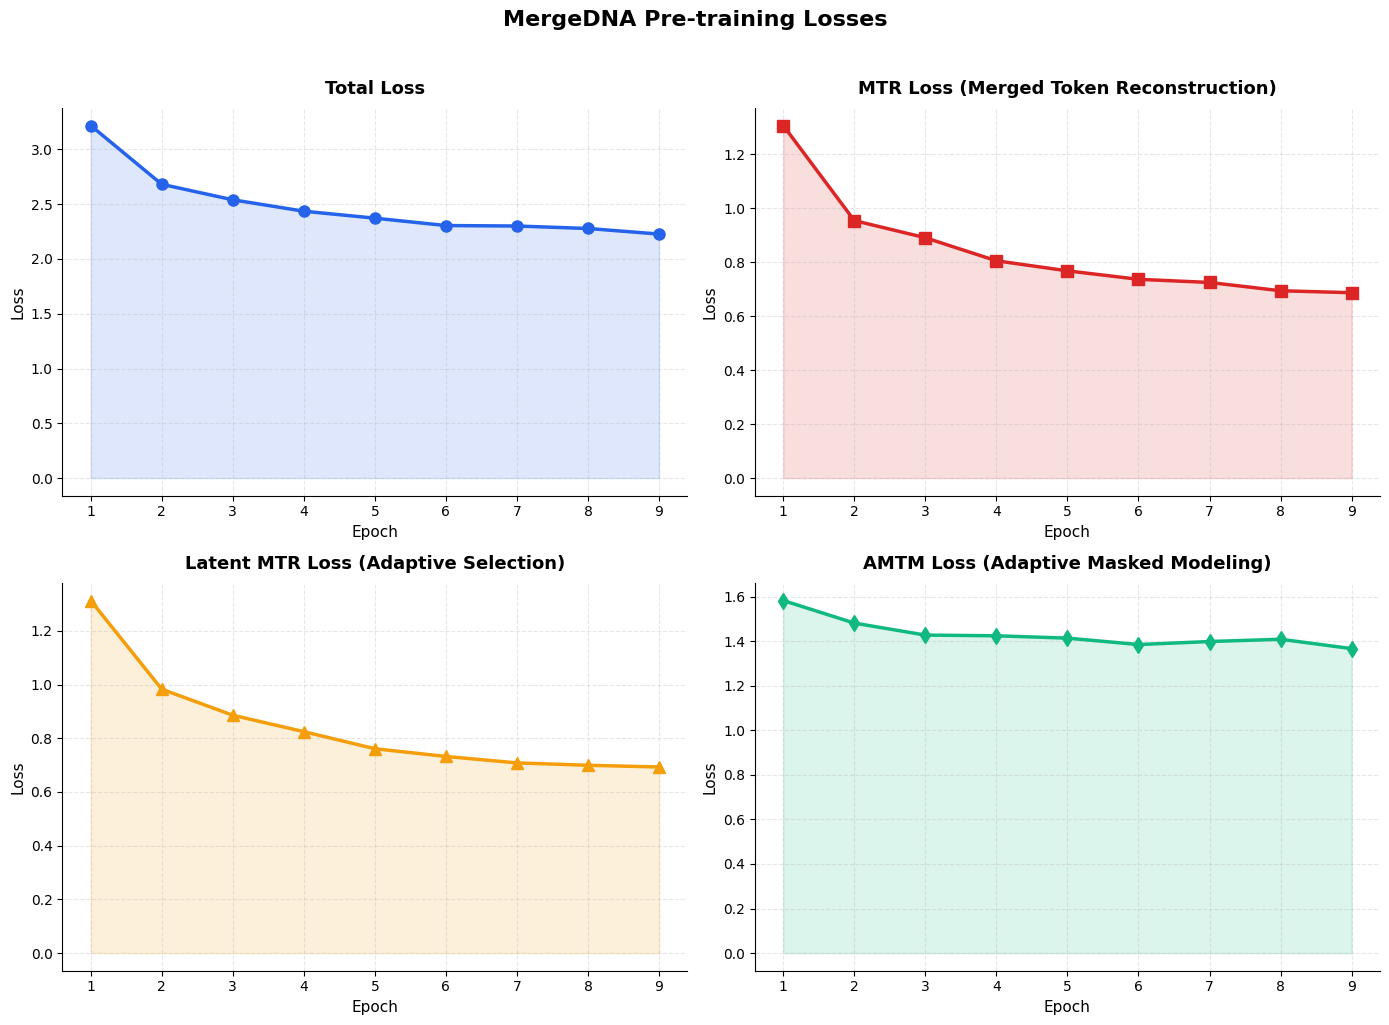


Training curves saved to ../checkpoints/training_curves.png


In [15]:
# Load training history from checkpoint (if training was interrupted)
if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=False)
    if 'history' in checkpoint:
        history = checkpoint['history']
        print(f"Loaded history from checkpoint (epoch {checkpoint['epoch'] + 1})")
    else:
        print("No history in checkpoint, using current history")
else:
    print("No checkpoint found, using current history")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('MergeDNA Pre-training Losses', fontsize=16, fontweight='bold', y=1.02)

colors = {
    'total': '#2563EB',   # Blue
    'mtr': '#DC2626',     # Red
    'latent': '#F59E0B',  # Amber
    'amtm': '#10B981'     # Emerald
}

epochs_range = range(1, len(history['total']) + 1)

# Total Loss
ax = axes[0, 0]
ax.plot(epochs_range, history['total'], 'o-', color=colors['total'], linewidth=2.5, markersize=8)
ax.fill_between(epochs_range, history['total'], alpha=0.15, color=colors['total'])
ax.set_title('Total Loss', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# MTR Loss
ax = axes[0, 1]
ax.plot(epochs_range, history['mtr'], 's-', color=colors['mtr'], linewidth=2.5, markersize=8)
ax.fill_between(epochs_range, history['mtr'], alpha=0.15, color=colors['mtr'])
ax.set_title('MTR Loss (Merged Token Reconstruction)', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Latent MTR Loss
ax = axes[1, 0]
ax.plot(epochs_range, history['latent'], '^-', color=colors['latent'], linewidth=2.5, markersize=8)
ax.fill_between(epochs_range, history['latent'], alpha=0.15, color=colors['latent'])
ax.set_title('Latent MTR Loss (Adaptive Selection)', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# AMTM Loss
ax = axes[1, 1]
ax.plot(epochs_range, history['amtm'], 'd-', color=colors['amtm'], linewidth=2.5, markersize=8)
ax.fill_between(epochs_range, history['amtm'], alpha=0.15, color=colors['amtm'])
ax.set_title('AMTM Loss (Adaptive Masked Modeling)', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../checkpoints/training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nTraining curves saved to ../checkpoints/training_curves.png")


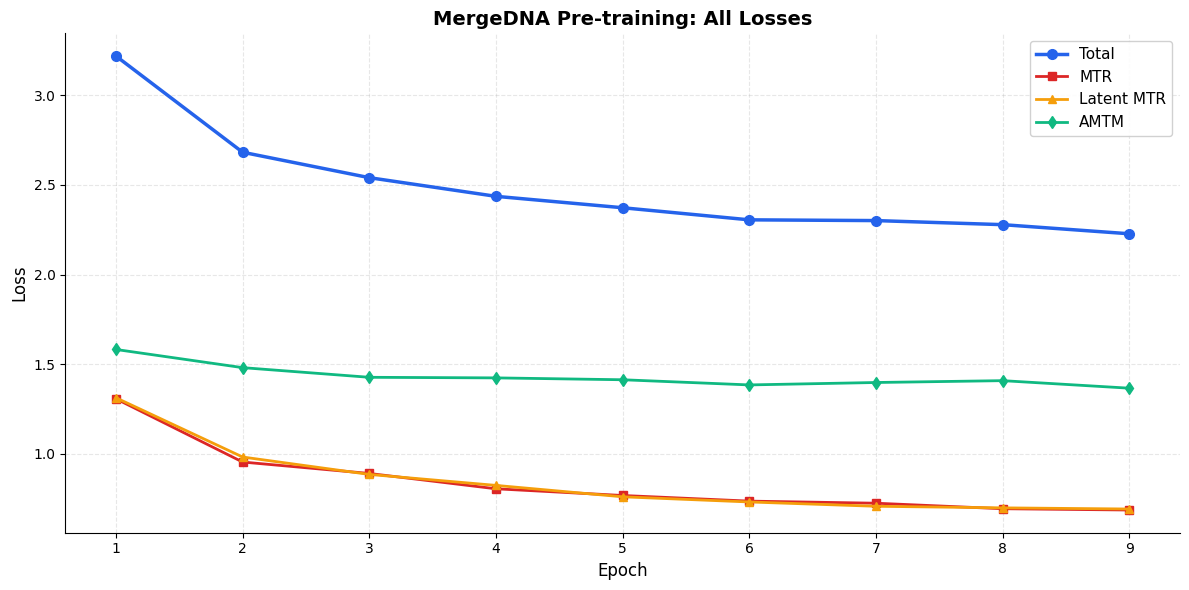


TRAINING SUMMARY

Final Losses (Epoch 9):
  • Total:  2.2272
  • MTR:    0.6874
  • Latent: 0.6931
  • AMTM:   1.3665

Improvement: 30.8% reduction in total loss


In [16]:
# Combined loss plot with all metrics
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs_range, history['total'], 'o-', label='Total', color=colors['total'], linewidth=2.5, markersize=7)
ax.plot(epochs_range, history['mtr'], 's-', label='MTR', color=colors['mtr'], linewidth=2, markersize=6)
ax.plot(epochs_range, history['latent'], '^-', label='Latent MTR', color=colors['latent'], linewidth=2, markersize=6)
ax.plot(epochs_range, history['amtm'], 'd-', label='AMTM', color=colors['amtm'], linewidth=2, markersize=6)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('MergeDNA Pre-training: All Losses', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../checkpoints/combined_losses.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Training summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nFinal Losses (Epoch {len(history['total'])}):")
print(f"  • Total:  {history['total'][-1]:.4f}")
print(f"  • MTR:    {history['mtr'][-1]:.4f}")
print(f"  • Latent: {history['latent'][-1]:.4f}")
print(f"  • AMTM:   {history['amtm'][-1]:.4f}")

if len(history['total']) > 1:
    improvement = (history['total'][0] - history['total'][-1]) / history['total'][0] * 100
    print(f"\nImprovement: {improvement:.1f}% reduction in total loss")


## Inference: Reconstruction (Autoencoding)
- **Input**: Full DNA sequence (e.g., `ATGC...`)
- **Action**: Compress → Process → Decompress 


In [17]:
# Load the best model from checkpoint
def load_model_from_checkpoint(checkpoint_path, device):
    """Load pre-trained model from checkpoint."""
    
    # Recreate model architecture
    local_encoder = LocalEncoder(DIM, merge_ratio=0.5).to(device)
    local_decoder = LocalDecoder(DIM).to(device)
    
    model = MergeDNAModel(
        local_encoder=local_encoder,
        local_decoder=local_decoder,
        dim=DIM,
        latent_enc_depth=LATENT_ENC_DEPTH,
        latent_dec_depth=LATENT_DEC_DEPTH,
        vocab_size=4
    ).to(device)
    
    # Load weights
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✓ Loaded model from epoch {checkpoint['epoch'] + 1}")
    print(f"  Training loss: {checkpoint['loss']:.4f}")
    
    return model

# Load the model
inference_model = load_model_from_checkpoint(CHECKPOINT_PATH, device)


✓ Loaded model from epoch 9
  Training loss: 2.2272


In [ ]:
# DNA mapping for decoding
IDX_TO_BASE = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}

def sequence_to_tensor(sequence, max_len=251):
    """Convert a DNA sequence string to tensor."""
    seq = sequence.strip().upper()
    indices = [DNA_VOCAB.get(base, 0) for base in seq[:max_len]]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    return torch.tensor(indices, dtype=torch.long)

def tensor_to_sequence(tensor):
    """Convert tensor back to DNA sequence string."""
    indices = tensor.cpu().numpy()
    return ''.join([IDX_TO_BASE[idx] for idx in indices])

@torch.no_grad()
def reconstruct_sequence(model, sequence, device):
    """
    Pure reconstruction: Compress → Process → Decompress
    Returns the reconstructed sequence and reconstruction error.
    """
    model.eval()
    
    # Convert to tensor
    x = sequence_to_tensor(sequence).unsqueeze(0).to(device)  # [1, N]
    x_onehot = F.one_hot(x, num_classes=4).float()  # [1, N, 4]
    
    # Forward pass through the autoencoder
    # 1. Local Encode (compress)
    z_l, s_local = model.local_encoder(x_onehot)
    
    # 2. Latent Encode (process)
    z_prime_l = model.latent_encoder(z_l)
    
    # 3. Latent Decode
    z_hat_l = model.latent_decoder(z_prime_l)
    
    # 4. Local Decode (decompress)
    x_hat = model.local_decoder(z_hat_l, s_local)
    
    # 5. Get logits and predictions
    logits = model.head(x_hat)  # [1, N, 4]
    predictions = logits.argmax(dim=-1)  # [1, N]
    
    # Calculate reconstruction error (cross-entropy per position)
    loss = F.cross_entropy(logits.view(-1, 4), x.view(-1), reduction='none')
    per_position_error = loss.view(x.shape)  # [1, N]
    
    # Get reconstructed sequence
    reconstructed = tensor_to_sequence(predictions[0])
    
    # Calculate accuracy
    accuracy = (predictions == x).float().mean().item()
    
    return {
        'original': sequence[:251],
        'reconstructed': reconstructed,
        'accuracy': accuracy,
        'mean_error': per_position_error.mean().item(),
        'per_position_error': per_position_error[0].cpu().numpy(),
        'compression_ratio': z_l.shape[1] / x.shape[1]
    }

print("Reconstruction functions defined")


✓ Reconstruction functions defined


In [21]:
# Test reconstruction on a normal sequence from the dataset
normal_sequence = test_seq[6]
result = reconstruct_sequence(inference_model, normal_sequence, device)

print("="*70)
print("RECONSTRUCTION TEST: Normal Sequence")
print("="*70)
print(f"\nOriginal:      {result['original'][:60]}...")
print(f"Reconstructed: {result['reconstructed'][:60]}...")
print(f"\nAccuracy:         {result['accuracy']*100:.2f}%")
print(f"Mean Error:       {result['mean_error']:.4f}")
print(f"Compression:      {result['compression_ratio']:.2f}x ({int(251 * result['compression_ratio'])} tokens)")

# Show mismatches
mismatches = sum(1 for a, b in zip(result['original'], result['reconstructed']) if a != b)
print(f"Mismatches:       {mismatches}/{len(result['original'])} positions")


RECONSTRUCTION TEST: Normal Sequence

Original:      T...
Reconstructed: CCGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...

Accuracy:         0.00%
Mean Error:       1.3962
Compression:      0.50x (126 tokens)
Mismatches:       1/1 positions
